In [1]:
#######################################################################################################
#Import Modules
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import calendar

Although the compositions of S&P500 Index change from time to time, I attempt to choose the top 5 out of top 200 current holdings for backtesting - more convenient when writing the program

In [2]:
#######################################################################################################
#Extract S&P500 Index Top200 Stickers
tickers = pd.read_csv('SP500_Holdings.csv')
tickers = tickers['Symbol'].iloc[:200].values.tolist()

In [3]:
#######################################################################################################
#Initialize variables (start date, end date, number of stocks to be selected as winners)
start = '2019-01-07'
end = '2022-07-31'
num_of_stocks = 5

In [4]:
#######################################################################################################
#Import data from yahoo finance API
df = yf.download(tickers, start = start, end = end)
prices = df['Adj Close']
print(prices.head())

[*********************100%***********************]  200 of 200 completed
                    A       AAPL       ABBV        ABT         ACN  \
Date                                                                 
2019-01-07  65.179100  35.803490  75.197006  65.145546  134.674927   
2019-01-08  66.134621  36.486012  75.546501  64.363403  138.080841   
2019-01-09  67.519112  37.105610  73.066826  65.437683  138.775345   
2019-01-10  68.152870  37.224201  73.391335  65.098442  139.869400   
2019-01-11  68.620872  36.858738  73.482887  65.334030  139.117828   

                  ADBE        ADI        ADM         ADP        ADSK  ...  \
Date                                                                  ...   
2019-01-07  229.259995  77.830894  37.870224  121.350952  132.720001  ...   
2019-01-08  232.679993  79.729645  38.574875  122.066795  133.869995  ...   
2019-01-09  235.429993  81.750031  38.909142  122.178375  136.770004  ...   
2019-01-10  237.770004  82.881790  39.180141  123.1

In [5]:
#######################################################################################################
#Calculate the winners in each week
daily_return = np.log(prices/prices.shift(1))
weekly_return = daily_return.resample('W').agg(lambda x: x.sum())
weekly_winners_index = weekly_return.apply(lambda s, n: s.nlargest(n).index, axis= 1, n = num_of_stocks)

#Calculate the winners in each month
monthly_return = daily_return.resample('M').agg(lambda x: x.sum())
monthly_winners_index = monthly_return.apply(lambda s, n: s.nlargest(n).index, axis= 1, n = num_of_stocks)

print("Weekly Winners: \n", weekly_winners_index.head())
print("Monthly Winners: \n",monthly_winners_index.head())

Weekly Winners: 
 Date
2019-01-13    Index(['UNP', 'MCHP', 'ADI', 'GM', 'NSC'], dty...
2019-01-20    Index(['GS', 'BAC', 'C', 'EW', 'SCHW'], dtype=...
2019-01-27    Index(['LRCX', 'AMAT', 'FISV', 'MU', 'IBM'], d...
2019-02-03    Index(['CHTR', 'NOW', 'AMD', 'GE', 'ANTM'], dt...
2019-02-10    Index(['EL', 'MRNA', 'CMG', 'EA', 'MCHP'], dty...
Freq: W-SUN, dtype: object
Monthly Winners: 
 Date
2019-01-31    Index(['LRCX', 'ANTM', 'FB', 'ADI', 'AMD'], dt...
2019-02-28    Index(['MRNA', 'CDNS', 'EL', 'CMG', 'BA'], dty...
2019-03-31    Index(['CMG', 'NVDA', 'SNPS', 'EW', 'AMT'], dt...
2019-04-30    Index(['QCOM', 'MRNA', 'DIS', 'F', 'STZ'], dty...
2019-05-31    Index(['CNC', 'LHX', 'PSA', 'CME', 'EQIX'], dt...
Freq: M, dtype: object


In [6]:
#######################################################################################################
#Buy the winners (each in equal proportions) at the end of this week and hold them for one week
weekly_strategy = pd.DataFrame()

for i in range(len(weekly_winners_index) - 1):
    weekly_winners = weekly_winners_index[i].values.tolist()
    weekend = weekly_return.index[i+1]
    weekly_winners_return = daily_return.loc[weekend-timedelta(days = 6):weekend-timedelta(days = 2), weekly_return.columns.isin(weekly_winners)]
    weekly_winners_return['mean return'] = weekly_winners_return.mean(axis = 1)
    weekly_strategy = weekly_strategy.append(weekly_winners_return)


weekly_strategy = weekly_strategy['mean return']

In [7]:
#######################################################################################################
#Buy the winners (each in equal proportions) at the end of this month and hold them for one month
monthly_strategy = pd.DataFrame()

for i in range(len(monthly_winners_index) - 1):
    monthly_winners = monthly_winners_index[i].values.tolist()
    monthend = pd.to_datetime(monthly_return.index[i+1], format = '%Y-%m-%d')
    daysInMonth= int(calendar.monthrange(monthend.year, monthend.month)[1])
    monthly_winners_return = daily_return.loc[monthend-timedelta(days = daysInMonth-1):monthend, monthly_return.columns.isin(monthly_winners)]
    monthly_winners_return['mean return'] = monthly_winners_return.mean(axis = 1)
    monthly_strategy = monthly_strategy.append(monthly_winners_return)

monthly_strategy = monthly_strategy['mean return']

In [8]:
#######################################################################################################
#Assign S&P500 Index as our benchmark
sp500 = yf.download('SPY', start = start, end = end)
sp500['returns'] = np.log(sp500['Adj Close']/sp500['Adj Close'].shift(1))

[*********************100%***********************]  1 of 1 completed


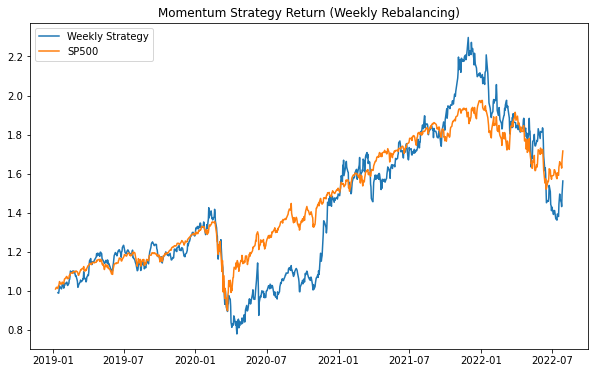

In [9]:
#######################################################################################################
#Plot the returns driven by the Strategy and the S&P500 Index
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title('Momentum Strategy Return (Weekly Rebalancing)')
ax.plot(weekly_strategy.cumsum().apply(np.exp), label = 'Weekly Strategy')
ax.plot(sp500['returns'].cumsum().apply(np.exp), label = 'SP500')
ax.legend()


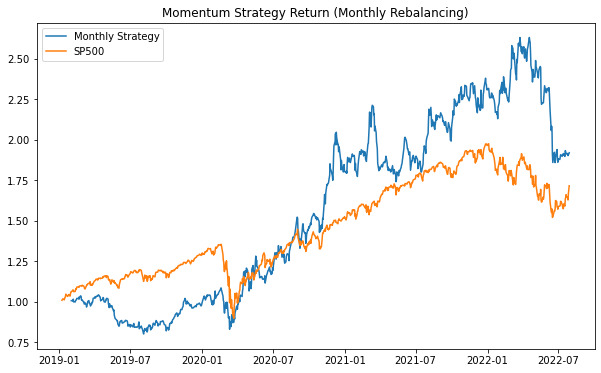

In [10]:
#######################################################################################################
#Plot the returns driven by the Strategy and the S&P500 Index
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title('Momentum Strategy Return (Monthly Rebalancing)')
ax.plot(monthly_strategy.cumsum().apply(np.exp), label = 'Monthly Strategy')
ax.plot(sp500['returns'].cumsum().apply(np.exp), label = 'SP500')
ax.legend()

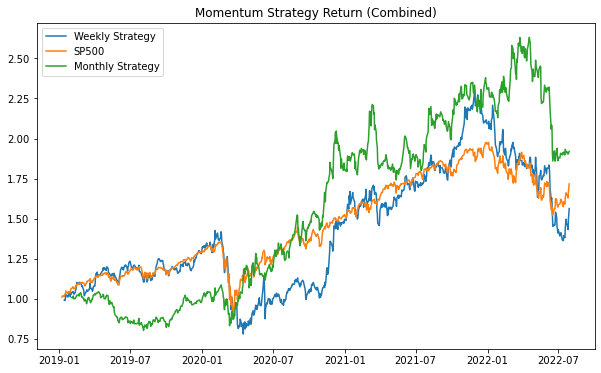

In [11]:
#######################################################################################################
#Combined Graphs
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title('Momentum Strategy Return (Combined)')
ax.plot(weekly_strategy.cumsum().apply(np.exp), label = 'Weekly Strategy')
ax.plot(sp500['returns'].cumsum().apply(np.exp), label = 'SP500')
ax.plot(monthly_strategy.cumsum().apply(np.exp), label = 'Monthly Strategy')
ax.legend()